In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import cv2
import os

dataset_path = "/content/gdrive/My Drive/Training_Test"
photo_path = os.path.join(dataset_path, 'images_train/')
sketch_path = os.path.join(dataset_path, 'sketches_train/')


def load_img(path):
    img = cv2.imread(path)/255
    return cv2.resize(img, (100,100))


def get_dict():
    
    photo_dictionary = {}

    for category in os.listdir(photo_path):
        category_path = os.path.join(photo_path, category)

        photo_dictionary[category] = os.listdir(category_path)

    sketch_dictionary = {}

    for category in os.listdir(sketch_path):
        category_path = os.path.join(sketch_path, category)

        sketch_dictionary[category] = os.listdir(category_path) 
    
    return photo_dictionary, sketch_dictionary


def get_batch(photo_dictionary, sketch_dictionary):
    
    
    l = []
    p_ = []
    s_ = []

    for _ in range(128): 

        if np.random.uniform() >= 0.5:

            photo_class = np.random.choice(list(photo_dictionary))
            photo = np.random.choice(photo_dictionary[photo_class])
            photo_dictionary[photo_class].remove(photo)
            p = photo_class + '/' + photo

            sketch_class = photo_class
            sketch = np.random.choice(sketch_dictionary[sketch_class])
            sketch_dictionary[sketch_class].remove(sketch)
            s = sketch_class + '/' + sketch
            label = 1

        else:

            x = list(photo_dictionary)
            photo_class = np.random.choice(x)
            photo = np.random.choice(photo_dictionary[photo_class])
            photo_dictionary[photo_class].remove(photo)
            p = photo_class + '/' + photo
            x.remove(photo_class)

            sketch_class = np.random.choice(x)
            sketch = np.random.choice(sketch_dictionary[sketch_class])
            sketch_dictionary[sketch_class].remove(sketch)
            s = sketch_class + '/' + sketch
            label = 0

        p_.append(os.path.join(dataset_path, 'images_train/', p))
        s_.append(os.path.join(dataset_path, 'sketches_train/', s))
        l.append(label)
    
    images = np.array([load_img(i) for i in p_])
    sketches = np.array([load_img(i) for i in s_])
    labels = np.array(l)

    return images, sketches, labels

In [0]:
import tensorflow as tf

def mynet(inp, reuse=False):
    with tf.variable_scope("model"):
        print(inp.shape)
        with tf.variable_scope("conv1") as scope:
            net = tf.contrib.layers.conv2d(inp, 32, 15, 
                                        stride=1,
                                        activation_fn=tf.nn.relu, 
                                        padding='VALID',
                                        weights_initializer=tf.keras.initializers.he_normal(),
                                        scope=scope,
                                        reuse=reuse)
            
            print(net.shape)
            
            net = tf.contrib.layers.max_pool2d(net, kernel_size=2, stride=2)
                                    
            net = tf.contrib.layers.batch_norm(net, reuse=reuse, scope=scope)
            
            print(net.shape)
            

        with tf.variable_scope("conv2") as scope:
            net = tf.contrib.layers.conv2d(net, 64, 8,
                                        stride=1,
                                        activation_fn=tf.nn.relu, 
                                        padding='VALID',
                                        weights_initializer=tf.keras.initializers.he_normal(),
                                        scope=scope,
                                        reuse=reuse)
            
            print(net.shape)
            
            net = tf.contrib.layers.max_pool2d(net, kernel_size=3, stride=3)
                    
            net = tf.contrib.layers.batch_norm(net, reuse=reuse, scope=scope)
            
            print(net.shape)
        
        
        with tf.variable_scope("conv3") as scope:
            net = tf.contrib.layers.conv2d(net, 256, 5, 
                                        stride=1,
                                        activation_fn=tf.nn.relu,
                                        padding='VALID',
                                        weights_initializer=tf.keras.initializers.he_normal(),
                                        scope=scope,
                                        reuse=reuse)
            
            print(net.shape)
            
            net = tf.contrib.layers.max_pool2d(net, kernel_size=2, stride=2)

            net = tf.contrib.layers.batch_norm(net, reuse=reuse, scope=scope)
            
            print(net.shape)

        
        with tf.variable_scope("fc1") as scope:
            net = tf.contrib.layers.flatten(net)
            print(net.shape)
        
        with tf.variable_scope("fc2") as scope:
            net = tf.contrib.layers.fully_connected(net, 64, 
                                                    activation_fn=tf.nn.relu, 
                                                    reuse=reuse, 
                                                    scope=scope)
            print(net.shape)
        
        
    return net


def contrastive_loss(model1, model2, y, margin):
    with tf.name_scope("contrastive-loss"):
        d = tf.sqrt(1e-6+tf.reduce_sum(tf.pow(model1-model2, 2), 1, keepdims=True))
        tmp = y * tf.square(d)    
        tmp2 = (1 - y) * tf.square(tf.maximum((margin - d),0))
    return tf.reduce_mean(tmp + tmp2)/2

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
left = tf.placeholder(tf.float32, [None, 100, 100, 3], name='left')
right = tf.placeholder(tf.float32, [None, 100, 100, 3], name='right')

label = tf.placeholder(tf.int32, [None, 1], name='label') # 1 if same, 0 if different
label = tf.to_float(label)

margin = 1

left_output = mynet(left, reuse=False)
right_output = mynet(right, reuse=True)

loss = contrastive_loss(left_output, right_output, label, margin)
optim = tf.train.AdamOptimizer(0.0005).minimize(loss)

init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

W0716 17:38:07.841377 140110320473984 deprecation.py:323] From <ipython-input-4-e95f3fac78d4>:5: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


(?, 100, 100, 3)


W0716 17:38:09.975004 140110320473984 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



(?, 86, 86, 32)
(?, 43, 43, 32)
(?, 36, 36, 64)
(?, 12, 12, 64)
(?, 8, 8, 256)


W0716 17:38:10.646729 140110320473984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


(?, 4, 4, 256)
(?, 4096)


W0716 17:38:11.304372 140110320473984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(?, 64)
(?, 100, 100, 3)
(?, 86, 86, 32)
(?, 43, 43, 32)
(?, 36, 36, 64)
(?, 12, 12, 64)
(?, 8, 8, 256)
(?, 4, 4, 256)
(?, 4096)
(?, 64)


In [0]:
test_image_paths = []
for category in os.listdir(photo_path):
    category_path = os.path.join(photo_path, category + '/')
    image_paths = np.random.choice(os.listdir(category_path), size=20, replace=False)
    for i in range(20):
        test_image_paths.append(category_path + image_paths[i])
np.random.shuffle(test_image_paths)
len(np.unique(test_image_paths))

2500

In [0]:
test_sketch_path = sketch_path + np.random.choice(os.listdir(sketch_path)) 
test_sketch_path = test_sketch_path + '/' + np.random.choice(os.listdir(test_sketch_path))
test_sketch_path

'/content/gdrive/My Drive/Training_Test/sketches_train/table/n04379243_27166-1.png'

In [0]:
test_sketch = load_img(test_sketch_path)
test_sketch = np.expand_dims(test_sketch, 0)
test_sketch.shape

(1, 100, 100, 3)

In [0]:
test_images = []
for path in test_image_paths:
    test_images.append(load_img(path))
test_images = np.array(test_images)
test_images.shape

(2500, 100, 100, 3)

In [0]:
from PIL import Image
Image.open(test_sketch_path)

In [0]:
saver = tf.train.Saver()

In [0]:
saver.restore(sess, "/content/gdrive/My Drive/models/siamese/finalmodel/finalmodel")


W0716 17:38:34.173709 140110320473984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [0]:
for epoch in range(400):
    print(epoch)
    photo_dictionary, sketch_dictionary = get_dict()
    p_batch, s_batch, lab_batch = get_batch(photo_dictionary, sketch_dictionary)
    lab_batch = lab_batch.reshape(-1, 1)
    [_, loss_] = sess.run([optim,loss], {left: p_batch, right: s_batch, label:lab_batch})
    
    
    if epoch%10==0:
        
        sketch_repr = sess.run([left_output], {left: test_sketch})
        sketch_repr = np.squeeze(np.array(sketch_repr), 1)
        print(sketch_repr.shape)
        sketch_representations = np.tile(sketch_repr, 2496).reshape(2496, 64)
        print(sketch_representations.shape)
        
        batch_size = 8
        n_batches = len(test_images) // batch_size
        image_representations = []

        for i in range(n_batches):
            img_repr = sess.run([left_output], {left: test_images[i*batch_size : (i+1)*batch_size]})
            img_repr = np.squeeze(np.array(img_repr), 0)
            image_representations.append(img_repr)
        image_representations = np.vstack(image_representations)

        diff = np.sqrt(np.mean((sketch_representations - image_representations)**2, -1))
        top_k = np.argsort(diff)[:5]

        print ('##' + str(epoch) + ' : loss == ' + str(loss_))

        plt.figure(figsize=(20, 20))
        for i in range(5):    
            img = mpimg.imread(test_image_paths[top_k[i]])
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
        plt.show()

In [0]:
saver.save(sess, '/content/gdrive/My Drive/models/siamese/modelfinal')

In [0]:
saver.restore(sess, '/content/gdrive/My Drive/models/siamese/modelv3/modelfinalv3')

W0716 05:14:04.368748 139650437347200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [0]:
def eval_MAP_K(query_set, search_set, query_label, search_set_label, K):
    query_class_arr = query_set
    search_set_class_arr = search_set

    query_label_arr = query_label
    query_label_arr.astype(int)
    search_set_label_arr = search_set_label
    search_set_label_arr.astype(int)

    num_query_sample = query_label_arr.shape[0]

    dist_q_search_class = cdist(query_class_arr,search_set_class_arr,metric='euclidean')

    AP=0
    for query_count in range(0,num_query_sample):

        actual_label = query_label_arr[query_count]
        value=dist_q_search_class[query_count,:]
        sorted_value_idx=value.argsort()
        predicted_K_label = search_set_label_arr[sorted_value_idx[0:K]]
        L=np.sum((np.in1d(predicted_K_label,actual_label)).astype(int))

        P=0
        for r in range(0,K):
            rtr_label_r = predicted_K_label[:(r+1)]
            l=np.sum((np.in1d(rtr_label_r,actual_label)).astype(int))
            precision=l/(r+1)
            if actual_label==predicted_K_label[r]:
                delta=1
            else:
                delta=0
            P=P+(precision*delta)
        if L!=0:
            AP=AP+((1/L)*P)
    map_K=AP/num_query_sample
    return map_K

In [0]:
sketch_set = np.load('/content/gdrive/My Drive/numpy arrays/sketches/testimagedata.npy')
sketch_lab = np.load('/content/gdrive/My Drive/numpy arrays/sketches/testimagelabels.npy')


In [0]:
image_set = np.load('/content/gdrive/My Drive/numpy arrays/images/testimagedata.npy')
image_lab = np.load('/content/gdrive/My Drive/numpy arrays/images/testimagelabels.npy')

In [0]:
image_set.shape

(1291, 100, 100, 3)

In [0]:
batch_size = 8
n_batches = len(image_set) // 8
image_representations = []
sketch_representations = []
for i in range(n_batches):
    img_repr = sess.run([left_output], {left: image_set[i*batch_size : (i+1)*batch_size]})
    image_representations.append(img_repr)

    
n_batches = len(sketch_set) // 8
   
for i in range(n_batches):
    sketch_repr = sess.run([left_output], {left: sketch_set[i*batch_size : (i+1)*batch_size]})
    sketch_representations.append(sketch_repr)
    

In [0]:
sketch_representations = np.vstack(sketch_representations)

In [0]:
image_representations = np.vstack(image_representations)

In [0]:
sketch_representations = sketch_representations.reshape(-1,64)
image_representations = image_representations.reshape(-1,64)

In [0]:
from scipy.spatial.distance import cdist
eval_MAP_K(sketch_representations, image_representations, sketch_lab[:7336], image_lab[:1288], 100)

0.026422974023255375

In [0]:
from PIL import Image

In [0]:
import numpy as np

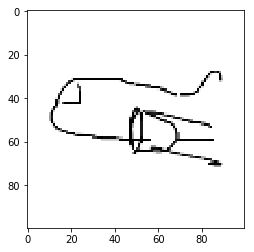

In [0]:
import matplotlib.pyplot as plt
plt.imshow(sketch_set[3]*255)